# Imports

In [1]:
%pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 977.3/977.3 kB 17.5 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [7]:
import torch
import torchvision
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models.feature_extraction import create_feature_extractor
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Replacing backbone and initialization

In [8]:
with open("/kaggle/working/yolo11-efficientnet.yaml", "w") as f:
    f.write("""
nc: 80 # number of classes
scales:
  # [depth, width, max_channels]
  n: [0.50, 0.25, 1024]

backbone:
  - [-1, 1, TorchVision, [1280, efficientnet_b0, DEFAULT, True, 2, True]] # 0

head:
  # Extract features from EfficientNet
  - [0, 1, Index, [40, 4]]           # 1: P3 raw (stride 8)
  - [0, 1, Index, [112, 6]]          # 2: P4 raw (stride 16)
  - [0, 1, Index, [320, 8]]          # 3: P5 raw (stride 32)

  # Project to standard YOLOv11 base channels
  - [1, 1, Conv, [256, 1, 1]]        # 4: P3 → 256
  - [2, 1, Conv, [512, 1, 1]]        # 5: P4 → 512
  - [3, 1, Conv, [1024, 1, 1]]       # 6: P5 → 1024

  # FPN: P5 → P4
  - [6, 1, nn.Upsample, [None, 2, "nearest"]]  # 7: upsample P5
  - [[7, 5], 1, Concat, [1]]                   # 8: P5 + P4
  - [-1, 2, C3k2, [512, False]]                # 9: fused P4

  # FPN: P4 → P3
  - [9, 1, nn.Upsample, [None, 2, "nearest"]]  # 10: upsample P4
  - [[10, 4], 1, Concat, [1]]                  # 11: + P3
  - [-1, 2, C3k2, [256, False]]                # 12: fused P3

  # PAN: P3 → P4
  - [12, 1, Conv, [256, 3, 2]]                 # 13: downsample
  - [[13, 9], 1, Concat, [1]]                  # 14
  - [-1, 2, C3k2, [512, False]]                # 15: refined P4

  # PAN: P4 → P5
  - [15, 1, Conv, [512, 3, 2]]                 # 16: downsample
  - [[16, 6], 1, Concat, [1]]                  # 17
  - [-1, 2, C3k2, [1024, True]]                # 18: refined P5

  # Final detection layers
  - [[12, 15, 18], 1, Detect, [nc]]            # 19
  

  
# backbone layers:
# 0 torch.Size([1, 3, 640, 640])
# 1 torch.Size([1, 32, 320, 320])
# 2 torch.Size([1, 16, 320, 320])
# 3 torch.Size([1, 24, 160, 160])
# 4 torch.Size([1, 40, 80, 80])
# 5 torch.Size([1, 80, 40, 40])
# 6 torch.Size([1, 112, 40, 40])
# 7 torch.Size([1, 192, 20, 20])
# 8 torch.Size([1, 320, 20, 20])
# 9 torch.Size([1, 1280, 20, 20])
""")


model = YOLO("/kaggle/working/yolo11-efficientnet.yaml", task="detect")

WARNING ⚠️ no model scale passed. Assuming scale='n'.


# Data

In [10]:
import os

with open("/kaggle/working/data.yaml", "w") as f:
    f.write("""train: /kaggle/input/seadronessee-yolo-15/seaDronesSee_yolo/images/train
val: /kaggle/input/seadronessee-yolo-15/seaDronesSee_yolo/images/val
test: /kaggle/input/seadronessee-yolo-15/seaDronesSee_yolo/images/test
nc: 1
names: ["human"]""")

# Fine-tuning

In [11]:
model.train(
    data="/kaggle/working/data.yaml",
    epochs=200,
    patience=10,
    imgsz=640,
    batch=16,
    name="yolo11_efficientnet_epoch"
)

!zip -r yolo11_efficientnet.zip /kaggle/working

Ultralytics 8.3.101 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/yolo11-efficientnet.yaml, data=/kaggle/working/data.yaml, epochs=200, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolo11_efficientnet_epoch, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=F

100%|██████████| 755k/755k [00:00<00:00, 17.6MB/s]


Overriding model.yaml nc=80 with nc=1
WARNING ⚠️ no model scale passed. Assuming scale='n'.

                   from  n    params  module                                       arguments                     
  0                  -1  1   4007548  ultralytics.nn.modules.block.TorchVision     ['efficientnet_b0', 'DEFAULT', True, 2, True]
  1                   0  1         0  ultralytics.nn.modules.conv.Index            [4]                           
  2                   0  1         0  ultralytics.nn.modules.conv.Index            [6]                           
  3                   0  1         0  ultralytics.nn.modules.conv.Index            [8]                           
  4                   1  1      2688  ultralytics.nn.modules.conv.Conv             [40, 64, 1, 1]                
  5                   2  1     14592  ultralytics.nn.modules.conv.Conv             [112, 128, 1, 1]              
  6                   3  1     82432  ultralytics.nn.modules.conv.Conv             [320, 256, 

100%|██████████| 5.35M/5.35M [00:00<00:00, 74.8MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/seadronessee-yolo-15/seaDronesSee_yolo/labels/train... 982 images, 0 backgrounds, 0 corrupt: 100%|██████████| 982/982 [00:04<00:00, 208.96it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-15/seaDronesSee_yolo/labels is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/input/seadronessee-yolo-15/seaDronesSee_yolo/labels/val... 122 images, 0 backgrounds, 0 corrupt: 100%|██████████| 122/122 [00:00<00:00, 211.87it/s]

val: WARNING ⚠️ /kaggle/input/seadronessee-yolo-15/seaDronesSee_yolo/images/val/9567.jpg: 1 duplicate labels removed
val: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-15/seaDronesSee_yolo/labels is not writeable, cache not saved.


Plotting labels to runs/detect/yolo11_efficientnet_epoch/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 93 weight(decay=0.0), 132 weight(decay=0.0005), 131 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolo11_efficientnet_epoch
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200       7.2G      3.952       75.7      3.038         39        640: 100%|██████████| 62/62 [00:39<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]

                   all        122        635          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      8.99G      4.144      8.313      2.112         61        640: 100%|██████████| 62/62 [00:33<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.99it/s]

                   all        122        635      0.201       0.18     0.0658     0.0123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      8.99G      3.323       2.88      1.353         38        640: 100%|██████████| 62/62 [00:34<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.32it/s]

                   all        122        635      0.354      0.299      0.203     0.0483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      8.99G      3.085      2.404       1.23         74        640: 100%|██████████| 62/62 [00:34<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]

                   all        122        635      0.453      0.384      0.278     0.0593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      8.99G      3.018      2.272      1.205         30        640: 100%|██████████| 62/62 [00:34<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.24it/s]

                   all        122        635      0.524      0.397       0.35     0.0844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      8.99G       2.92       2.07      1.183         52        640: 100%|██████████| 62/62 [00:36<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]

                   all        122        635      0.429      0.395      0.263     0.0647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      8.99G      2.834      1.944      1.186         23        640: 100%|██████████| 62/62 [00:35<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]

                   all        122        635      0.527      0.433      0.398      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      8.99G       2.83      1.859      1.137         36        640: 100%|██████████| 62/62 [00:35<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]

                   all        122        635      0.574      0.452      0.403      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      8.99G      2.742      1.749      1.139         59        640: 100%|██████████| 62/62 [00:32<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]

                   all        122        635      0.542      0.422      0.397      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      8.99G      2.675      1.653      1.117         42        640: 100%|██████████| 62/62 [00:32<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.30it/s]

                   all        122        635      0.527      0.444      0.388      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      8.99G      2.661      1.589      1.147         39        640: 100%|██████████| 62/62 [00:36<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.21it/s]

                   all        122        635      0.541      0.449      0.427      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      8.99G      2.576       1.45      1.097         82        640: 100%|██████████| 62/62 [00:33<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.32it/s]

                   all        122        635      0.544      0.446      0.398      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      8.99G      2.607      1.476      1.133         57        640: 100%|██████████| 62/62 [00:35<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]

                   all        122        635      0.631      0.513      0.491      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      8.99G      2.608       1.43      1.081         59        640: 100%|██████████| 62/62 [00:29<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]

                   all        122        635      0.654      0.501      0.483      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      8.99G      2.582      1.381      1.087         66        640: 100%|██████████| 62/62 [00:29<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]

                   all        122        635       0.62      0.458      0.452      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      8.99G      2.506       1.31      1.092         45        640: 100%|██████████| 62/62 [00:28<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]

                   all        122        635      0.622      0.523      0.506      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      8.99G      2.541      1.316      1.114         66        640: 100%|██████████| 62/62 [00:33<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.17it/s]

                   all        122        635      0.556      0.487      0.443      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      8.99G       2.52      1.308      1.082         71        640: 100%|██████████| 62/62 [00:33<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.16it/s]

                   all        122        635      0.538      0.457      0.434      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      8.99G      2.469       1.23      1.063         49        640: 100%|██████████| 62/62 [00:33<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]

                   all        122        635      0.614      0.476      0.439      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      8.99G      2.459      1.255      1.089         33        640: 100%|██████████| 62/62 [00:36<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]

                   all        122        635      0.651      0.515      0.516      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      8.99G      2.481      1.248      1.067         66        640: 100%|██████████| 62/62 [00:32<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.44it/s]

                   all        122        635      0.714      0.518      0.553      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      8.99G      2.471      1.254      1.081         79        640: 100%|██████████| 62/62 [00:32<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]

                   all        122        635      0.676      0.494      0.535      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      8.99G      2.431      1.218      1.061         48        640: 100%|██████████| 62/62 [00:36<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]

                   all        122        635      0.716      0.509      0.534      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      8.99G      2.401      1.201      1.049         53        640: 100%|██████████| 62/62 [00:35<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.21it/s]

                   all        122        635       0.64      0.512      0.531      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      8.99G      2.393      1.192      1.063         42        640: 100%|██████████| 62/62 [00:35<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.23it/s]

                   all        122        635      0.661       0.52      0.544      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      8.99G      2.421      1.158       1.05         57        640: 100%|██████████| 62/62 [00:35<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]

                   all        122        635      0.641      0.515      0.521      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      8.99G      2.407      1.172      1.068         29        640: 100%|██████████| 62/62 [00:33<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.32it/s]

                   all        122        635      0.634       0.49      0.479      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      8.99G      2.398       1.15       1.04         51        640: 100%|██████████| 62/62 [00:36<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]

                   all        122        635      0.626       0.52      0.523      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      8.99G      2.387      1.124       1.05         53        640: 100%|██████████| 62/62 [00:34<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]

                   all        122        635      0.678      0.535      0.566      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      8.99G      2.373      1.125      1.049         51        640: 100%|██████████| 62/62 [00:35<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]

                   all        122        635      0.689      0.509      0.536      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      8.99G      2.358      1.124      1.059         56        640: 100%|██████████| 62/62 [00:35<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.26it/s]

                   all        122        635      0.726      0.509      0.543      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      8.99G      2.299      1.093      1.038         32        640: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.28it/s]

                   all        122        635      0.715      0.521      0.552      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      8.99G      2.337      1.108      1.053         33        640: 100%|██████████| 62/62 [00:37<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]

                   all        122        635       0.69      0.499      0.554      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      8.99G      2.339      1.114      1.036         69        640: 100%|██████████| 62/62 [00:32<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.32it/s]

                   all        122        635      0.734      0.523      0.552      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      8.99G      2.391      1.106      1.015         61        640: 100%|██████████| 62/62 [00:33<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]

                   all        122        635      0.715      0.506      0.552      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      8.99G      2.282      1.076      1.028         59        640: 100%|██████████| 62/62 [00:35<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]

                   all        122        635      0.675      0.542      0.559      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      8.99G      2.309      1.064      1.032         56        640: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]

                   all        122        635      0.663      0.517      0.527      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      8.99G       2.29      1.099      1.017         32        640: 100%|██████████| 62/62 [00:33<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.05it/s]

                   all        122        635      0.699      0.562      0.581      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      8.99G      2.285      1.061      1.019         52        640: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]

                   all        122        635       0.71      0.558      0.572      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      8.99G      2.284      1.029      1.035         57        640: 100%|██████████| 62/62 [00:34<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]

                   all        122        635      0.721       0.48      0.523      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      8.99G      2.229      1.031      1.013         71        640: 100%|██████████| 62/62 [00:34<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]

                   all        122        635      0.716      0.524      0.555      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      8.99G      2.262      1.053      1.016         67        640: 100%|██████████| 62/62 [00:37<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.03it/s]

                   all        122        635      0.673      0.545      0.548      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      8.99G      2.251      1.042      1.018         41        640: 100%|██████████| 62/62 [00:36<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]

                   all        122        635      0.686      0.517      0.568      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      8.99G      2.167      1.004      1.015         59        640: 100%|██████████| 62/62 [00:35<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.32it/s]

                   all        122        635      0.762       0.52      0.589      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      8.99G      2.202      1.005      1.016         69        640: 100%|██████████| 62/62 [00:34<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.55it/s]

                   all        122        635      0.725      0.523      0.563      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      8.99G      2.196      1.004      1.006         31        640: 100%|██████████| 62/62 [00:35<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.19it/s]

                   all        122        635      0.709      0.523      0.579      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      8.99G      2.205      1.013      1.015         41        640: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.23it/s]

                   all        122        635      0.748      0.547      0.571      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      8.99G      2.152      0.983      1.014         46        640: 100%|██████████| 62/62 [00:31<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]

                   all        122        635      0.757       0.57      0.607      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      8.99G      2.206     0.9964     0.9917         47        640: 100%|██████████| 62/62 [00:35<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.31it/s]

                   all        122        635      0.715      0.539      0.567      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      8.99G      2.191      1.015      1.017         60        640: 100%|██████████| 62/62 [00:32<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]

                   all        122        635      0.752      0.548       0.59       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      8.99G      2.183     0.9687     0.9877         31        640: 100%|██████████| 62/62 [00:36<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.99it/s]

                   all        122        635       0.69       0.55      0.574      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      8.99G        2.1     0.9761     0.9943         40        640: 100%|██████████| 62/62 [00:35<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.28it/s]

                   all        122        635      0.691      0.542      0.571      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      8.99G      2.112     0.9746     0.9838         70        640: 100%|██████████| 62/62 [00:34<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]

                   all        122        635      0.692      0.578      0.581      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      8.99G       2.14     0.9954      0.994         69        640: 100%|██████████| 62/62 [00:33<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.33it/s]

                   all        122        635      0.701      0.539      0.557      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      8.99G      2.192     0.9999      1.001         35        640: 100%|██████████| 62/62 [00:34<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]

                   all        122        635      0.736      0.546        0.6      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      8.99G      2.096     0.9651     0.9787         49        640: 100%|██████████| 62/62 [00:35<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.30it/s]

                   all        122        635      0.741      0.573      0.602      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      8.99G      2.117     0.9979     0.9758         41        640: 100%|██████████| 62/62 [00:34<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]

                   all        122        635      0.696      0.555      0.574      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      8.99G      2.131     0.9678     0.9862         47        640: 100%|██████████| 62/62 [00:38<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.20it/s]

                   all        122        635      0.724      0.567      0.595      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      8.99G      2.126     0.9569     0.9984         53        640: 100%|██████████| 62/62 [00:33<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.30it/s]

                   all        122        635      0.694      0.558      0.584      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      8.99G      2.149     0.9804     0.9878         43        640: 100%|██████████| 62/62 [00:35<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.33it/s]

                   all        122        635      0.757      0.573      0.622      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      8.99G      2.096     0.9766     0.9972         56        640: 100%|██████████| 62/62 [00:33<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.59it/s]

                   all        122        635      0.717      0.554      0.586      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      8.99G      2.093     0.9496      1.001         47        640: 100%|██████████| 62/62 [00:32<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.57it/s]

                   all        122        635      0.682      0.533      0.563        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      8.99G      2.069     0.9383     0.9849         62        640: 100%|██████████| 62/62 [00:35<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.59it/s]

                   all        122        635      0.771      0.567      0.617      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      8.99G      2.078     0.9526     0.9877         54        640: 100%|██████████| 62/62 [00:32<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]

                   all        122        635      0.729      0.573      0.603      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      8.99G      2.051     0.9262     0.9753         63        640: 100%|██████████| 62/62 [00:33<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]

                   all        122        635      0.737      0.576      0.608      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      8.99G       2.09      0.935     0.9757         53        640: 100%|██████████| 62/62 [00:34<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]

                   all        122        635      0.719      0.567      0.589      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      8.99G      2.065     0.9411     0.9772         67        640: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]

                   all        122        635      0.762      0.553      0.613      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      8.99G      2.038     0.9292     0.9641         77        640: 100%|██████████| 62/62 [00:31<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]

                   all        122        635      0.748       0.57      0.608      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      8.99G      2.077     0.9352     0.9916         48        640: 100%|██████████| 62/62 [00:34<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]

                   all        122        635      0.812       0.55      0.619      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      8.99G      2.004     0.8863     0.9418         48        640: 100%|██████████| 62/62 [00:34<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.28it/s]

                   all        122        635      0.769      0.576      0.628      0.229
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 60, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



70 epochs completed in 0.714 hours.
Optimizer stripped from runs/detect/yolo11_efficientnet_epoch/weights/last.pt, 11.1MB
Optimizer stripped from runs/detect/yolo11_efficientnet_epoch/weights/best.pt, 11.1MB

Validating runs/detect/yolo11_efficientnet_epoch/weights/best.pt...
Ultralytics 8.3.101 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLO11-efficientnet summary: 288 layers, 5,323,775 parameters, 0 gradients, 10.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


                   all        122        635      0.757      0.575      0.622      0.232


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 5.0ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/yolo11_efficientnet_epoch
  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/runs/ (stored 0%)
  adding: kaggle/working/runs/detect/ (stored 0%)
  adding: kaggle/working/runs/detect/yolo11_efficientnet_epoch/ (stored 0%)
  adding: kaggle/working/runs/detect/yolo11_efficientnet_epoch/args.yaml (deflated 54%)
  adding: kaggle/working/runs/detect/yolo11_efficientnet_epoch/val_batch2_pred.jpg (deflated 8%)
  adding: kaggle/working/runs/detect/yolo11_efficientnet_epoch/confusion_matrix_normalized.png (deflated 38%)
  adding: kaggle/working/runs/detect/yolo11_efficientnet_epoch/val_batch1_labels.jpg (deflated 9%)
  adding: kaggle/working/runs/detect/yolo11_efficientnet_epoch/labels.jpg (deflated 32%)
  adding: kaggle/working/runs/detect/yolo11_efficientnet_epoch/train_batch1.jpg (deflated 5%)
  adding: kaggle/working/runs/detect/yolo11_efficientnet_epoch/labels_correlogr

# Testing

In [12]:
def show_img_with_boxes(res):
    img = res[0].plot()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


image 1/1 /kaggle/input/seadronessee-yolo-15/seaDronesSee_yolo/images/test/10157.jpg: 384x640 7 humans, 14.9ms
Speed: 2.2ms preprocess, 14.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


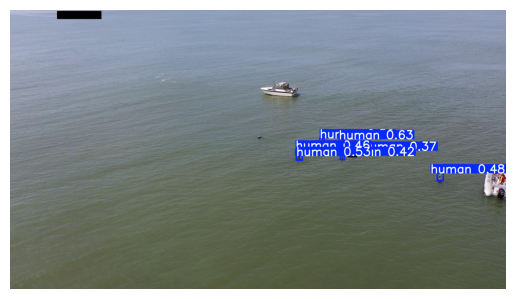

Ultralytics 8.3.101 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLO11-efficientnet summary: 288 layers, 5,323,775 parameters, 0 gradients, 10.6 GFLOPs


val: Scanning /kaggle/input/seadronessee-yolo-15/seaDronesSee_yolo/labels/test... 122 images, 0 backgrounds, 0 corrupt: 100%|██████████| 122/122 [00:00<00:00, 740.68it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-15/seaDronesSee_yolo/labels is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


                   all        122        630      0.636      0.525      0.517      0.186


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 1.2ms preprocess, 7.3ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/detect/val2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7890813c0e50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04

In [23]:
model = YOLO("/kaggle/working/runs/detect/yolo11_efficientnet_epoch/weights/best.pt")

img = "/kaggle/input/seadronessee-yolo-15/seaDronesSee_yolo/images/test/10157.jpg"

results = model(img)
show_img_with_boxes(results)

metrics = model.val(
    data="/kaggle/working/data.yaml",
    split="test"
)

print(metrics)